# Import Libraries

In [1]:
# Import built-in Python libs
import pickle
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List

# Import data science libs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Import deep learning libs
import pytorch_lightning as pl
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import weights & bias
import wandb

# Import data preprocessing libs
from tokenizers import Tokenizer, decoders, pre_tokenizers
from tokenizers.models import BPE
from tokenizers.normalizers import NFKC
from tokenizers.processors import TemplateProcessing
from tokenizers.trainers import BpeTrainer
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

# Download Datasets, Tokenizers, DataModule

In [21]:
config = {
    "enc_emb_dim": 300,
    "dec_emb_dim": 300,
    "enc_hid_dim": 512,
    "dec_hid_dim": 512,
    "enc_dropout": 0.3,
    "dec_dropout": 0.3,
    "lr": 1e-3,
    "batch_size": 64,
    "num_workers": 12,
    "precision": 16,
}

In [3]:
run = wandb.init(
    project="phonetic-translation",
    entity="windsuzu",
    group="experiments",
    job_type="baseline_rnn",
    config=config,
    reinit=True,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: windsuzu (use `wandb login --relogin` to force relogin)


## Raw Data

In [4]:
train_data_art = run.use_artifact("filtered_train:latest")
train_data_dir = train_data_art.download()

dev_data_art = run.use_artifact("dev:latest")
dev_data_dir = dev_data_art.download()

test_data_art = run.use_artifact("test:latest")
test_data_dir = test_data_art.download()

data_dir = {
    "train": train_data_dir,
    "dev": dev_data_dir,
    "test": test_data_dir,
}

wandb: Downloading large artifact filtered_train:latest, 99.47MB. 2 files... Done. 0:0:0


## Tokenizer

In [5]:
sentencepiece_tokenizer_art = run.use_artifact("sentencepiece:latest")
sentencepiece_tokenizer_dir = sentencepiece_tokenizer_art.download()
ch_tokenizer_dir = Path(sentencepiece_tokenizer_dir) / "ch_tokenizer.json"
jp_tokenizer_dir = Path(sentencepiece_tokenizer_dir) / "jp_tokenizer.json"

## DataModule

In [6]:
class SentencePieceDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir,
        src_tokenizer_dir,
        trg_tokenizer_dir,
        batch_size=128,
        num_workers=8,
        pin_memory=True,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.src_tokenizer_dir = src_tokenizer_dir
        self.trg_tokenizer_dir = trg_tokenizer_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

    def setup(self, stage=None):
        self.src_tokenizer = self._load_tokenizer(self.src_tokenizer_dir)
        self.trg_tokenizer = self._load_tokenizer(self.trg_tokenizer_dir)

        if stage == "fit":
            self.train_set = self._data_preprocess(self.data_dir["train"])
            self.val_set = self._data_preprocess(self.data_dir["dev"])

        if stage == "test":
            self.test_set = self._data_preprocess(self.data_dir["test"])

    def train_dataloader(self):
        return DataLoader(
            self.train_set,
            self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            collate_fn=self._data_batching_fn,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_set,
            self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            collate_fn=self._data_batching_fn,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_set,
            self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            collate_fn=self._data_batching_fn,
        )

    def _read_data_array(self, data_dir):
        with open(data_dir, encoding="utf8") as f:
            arr = f.readlines()
        return arr

    def _load_tokenizer(self, tokenizer_dir):
        return Tokenizer.from_file(str(tokenizer_dir))

    def _data_preprocess(self, data_dir):
        src_txt = self._read_data_array(Path(data_dir) / "ch.txt")
        trg_txt = self._read_data_array(Path(data_dir) / "jp.txt")
        parallel_txt = np.array(list(zip(src_txt, trg_txt)))
        return parallel_txt

    def _data_batching_fn(self, data_batch):
        data_batch = np.array(data_batch)  # shape=(batch_size, 2=src+trg)

        src_batch = data_batch[:, 0]  # shape=(batch_size, )
        trg_batch = data_batch[:, 1]  # shape=(batch_size, )
        
        # src_batch=(batch_size, longest_sentence)
        # trg_batch=(batch_size, longest_sentence)
        src_batch = self.src_tokenizer.encode_batch(src_batch)  
        trg_batch = self.trg_tokenizer.encode_batch(trg_batch)

        # We have to sort the batch by their non-padded lengths in descending order,
        # because the descending order can help in `nn.utils.rnn.pack_padded_sequence()`,
        # which it will help us ignoring the <pad> in training rnn.
        # https://meetonfriday.com/posts/4d6a906a
        src_batch, trg_batch = zip(
            *sorted(
                zip(src_batch, trg_batch),
                key=lambda x: sum(x[0].attention_mask),
                reverse=True,
            )
        )
        
        return src_batch, trg_batch

In [7]:
dm = SentencePieceDataModule(
    data_dir,
    ch_tokenizer_dir,
    jp_tokenizer_dir,
    config["batch_size"],
    config["num_workers"],
)

### Test DataModule

In [8]:
dm.setup("test")

In [9]:
input_dim = dm.src_tokenizer.get_vocab_size()
output_dim = dm.trg_tokenizer.get_vocab_size()
print(input_dim, output_dim)

src_pad_idx = dm.src_tokenizer.token_to_id("[PAD]")
print(src_pad_idx)

32000 32000
3


In [10]:
for src, trg in dm.test_dataloader():
    print(len(src), src[0])
    print(len(trg), trg[0])
    break

64 Encoding(num_tokens=105, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
64 Encoding(num_tokens=117, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


# Build Lightning Model

## Encoder



![](../assets/bi_encoder.png)

首先我們先輸入 embeded 過後的字來計算正向和反向的 hidden state:

$$
h_\overrightarrow{t} = \overrightarrow{\text{EncoderGRU}}(\text{emb}(x_\overrightarrow{t}), h_\overrightarrow{t-1})
\\
h_\overleftarrow{t} = \overleftarrow{\text{EncoderGRU}}(\text{emb}(x_\overleftarrow{t}), h_\overleftarrow{t-1})
$$

得到的 `outputs` 代表所有最後一層的 hidden states 的組合，我們會用 outputs 來計算 attention，也就是翻譯時要注意原句的哪些單字:

$$
h_1 = [h_\overrightarrow{1}; h_\overleftarrow{1}], h_2 = [h_\overrightarrow{2}; h_\overleftarrow{2}], \\
\text{outputs} = H = \left\{h_1, h_2, \cdots, h_T\right\}
$$

得到的 `hidden` 代表每一層最後一個時間點的 hidden states 的疊加，我們會用 hidden 做為 decoder 初始的 context vector `s0`:

$$
\overrightarrow{z} = h_\overrightarrow{T} \\
\overleftarrow{z} = h_\overleftarrow{T}
$$

因為 decoder 不是雙向，所以我們把 hidden 丟進一個 linear `g` 和 `tanh` 裡獲得濃縮後的 context vector `z`:

$$
z = \tanh(g(\text{cat}(\overrightarrow{z}, \overleftarrow{z}))) = s_0
$$



### Inputs

| variables   | use                                             | note                                              |
| ----------- | ----------------------------------------------- | ------------------------------------------------- |
| src         | 初始語言資料                                    | `shape=[batch_size, src_len]` (batch-first shape) |
| src_len     | batch 中每個句子的真實長度                      | `shape=[batch_size]`                              |
| input_dim   | 初始語言的 vocab_size                           | `src_tokenizer.get_vocab_size()`                  |
| emb_dim     | embedding_size                                  ||
| enc_hid_dim | Encoder 中 rnn 的 hidden_size                   ||
| dec_hid_dim | Decoder 中 rnn 的 hidden_size                   ||
| rnn         | 雙向 GRU, 吃 batch-first 的資料                 | `nn.GRU(emb_dim, enc_hid_dim, bidirectional = True, batch_first=True)`|
| fc          | 將雙向 context vector 輸出成單個 context vector | `nn.Linear(enc_hid_dim * 2, dec_hid_dim)`|

### Outputs

| variables        | use                                            | note                                     |
| ---------------- | ---------------------------------------------- | ---------------------------------------- |
| packed_embedded  | 將 `[PAD]` 刪掉包裝成 packed 格式              | `PackedSequence`                         |
| packed_outputs   | 沒有 `[PAD]` 的最後一層 hidden_states          | `PackedSequence`                         |
| enc_outputs      | 有 `[PAD]` 的最後一層 hidden_states            | `shape=[batch_size, src_len, enc_hid_dim*2]` |
| hidden           | 所有 layer 疊加的 context_vector               | `shape=[layer*2, batch_size, enc_hid_dim]`   |
| hidden[:2, :, :] | 最上面 forward layer 的 hidden_state           | `shape=[batch_size, enc_hid_dim]`            |
| hidden[:1, :, :] | 最上面 backward layer 的 hidden_state          | `shape=[batch_size, enc_hid_dim]`            |
| last_hidden      | 透過 torch.cat 組合最後一層 forward + backward | `shape=[batch_size, enc_hid_dim*2]`          |
| dec_hidden       | 經過 tanh + fc 得到的 context_vector           | `shape=[batch_size, dec_hid_dim]`

> - **Terminology Alert**😪:
>   - **outputs** 可以想成所有時間點的最後一層的 hidden_states 所組成
>   - **hidden** 可以想成所有 layer (forward + backward) 在最後時間點的 hidden_states 堆疊而成的 context_vector

問題一: 什麼是 packed_sequence?
> - [[Pytorch]Pack the data to train variable length sequences](https://meetonfriday.com/posts/4d6a906a)

問題二: outputs 和 hidden 差在哪?
> - [学会区分 RNN 的 output 和 state](https://zhuanlan.zhihu.com/p/28919765)
> - [LSTM/GRU中output和hidden的区别//其他问题](https://blog.csdn.net/yagreenhand/article/details/84893493)

<img src="../assets/output_vs_hidden.png" width=400>

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        # src     = [batch_size, src_len]
        # src_len = [batch_size]

        embedded = self.dropout(self.embedding(src))
        # embedded = [batch_size, src_len, emb_dim]
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to("cpu"), batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        # packed_outputs is a packed sequence containing all hidden states
        # hidden is now from the final non-padded element in the batch

        enc_outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        # enc_outputs is now a non-packed sequence

        # enc_outputs = [batch_size, src_len, enc_hid_dim*num_directions]
        #             = [forward_n + backward_n]
        #             = [last layer]

        # hidden  = [n_layers*num_directions, batch_size, enc_hid_dim]
        #         = [forward_1, backward_1, forward_2, backword_2, ...]

        # hidden[-2, :, : ] is the last of the forwards RNN
        # hidden[-1, :, : ] is the last of the backwards RNN

        last_hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        init_dec_hidden = torch.tanh(self.fc(last_hidden))

        # enc_outputs     = [batch_size, src_len, enc_hid_dim*2]  (we only have 1 layer)
        # init_dec_hidden = [batch_size, dec_hid_dim]

        return enc_outputs, init_dec_hidden

## Attention

![](../assets/seq2seq_encoder_attention.png)

先說結論，每次 attention layer 會產生一個 `src_len` 長度的陣列，代表在預測下一個字 $\hat{y}_{t+1}$ 的時間點時，對原句 `src` 中每一個 token 的專注度有多高。

🤯 每次需要給 attention layer 什麼?

1. decoder 前一個時間點的 hidden state $s_{t-1}$ (i.e., 第一個就是 encoder 的 `hidden` $z$ 也就是 $s_0$)
2. encoder 的 `outputs` $H$

而 attention layer 其實只是一個 linear layer，用來和 `tanh` 一起計算出一個能量值 $E_t$:

$$
E_t = \tanh(\text{attn}(s_{t-1}, H))
$$

因為 `enc_outputs` 的長度是 `src_len`，而 `hidden` 只是一個 scalar，所以我們必須把 `hidden` 拉到跟 `enc_outputs` 一樣長。 計算出來的 $E_t$ 可以想像成 `encoder_outputs` $H$ 和 `previous_decoder_hidden_state` $s_{t-1}$ 有多匹配。

因為算出來的能量值 $E_t$ 形狀是 `[src_len, hid_dim]`，我們可以把他帶入一個形狀是 `[hid_dim, 1]` linear layer $v$。最終得到一個形狀是 `[src_len]` 的 `attention_sequence`:

$$
\hat{a}_t = v(E_t)
$$

你可以想像 $v$ 裡面學習到的參數是一個權重，告訴我們能量值 $E_t$ 作用在 `encoder_outputs` 中每個 token 的權重有多少。

最後的最後， attention_sequence 會通過 softmax 讓所有機率加總為 1，其中會把 `attention_sequence` 和 `mask` 結合，讓對應在 [PAD] index 的 hidden state 都變成 -1e10 (會讓他們在套入 softmax 後變成 0)。

$$
a_t = \text{softmax}(\hat{a}_t)
$$

這個 $a_t$ 正是告訴我們在 decode 的當下，要注視原句的哪些 token!





### Inputs

| variable        | use                                                   | note                                          |
| --------------- | ----------------------------------------------------- | --------------------------------------------- |
| hidden          | encoder_hidden $s_0$ 或是 decoder_hidden $s_{t-1}$     | `shape=[batch_size, dec_hid_dim]`              |
| encoder_outputs | encoder_outputs $H$，也就是 encoder 最後一層的 hidden_states   | `shape=[batch_size, src_len, enc_hid_dim * 2]` |
| mask            | 用來遮罩的 tensor，1 是真實的 token，0 是 [PAD]            | `shape=[batch_size, src_len]`      |
| attn            | 用來匹配 `enc_outputs` 和 `hidden` 的 attention layer | `linear(enc_hid*2+dec_hid, dec_hid)` |
| v               | 用來學習 `attention` 權重的 linear layer              | `linear(dec_hid, 1)`                 |

### Outputs

| variable              | use                                                                                                       | note                                       |
| --------------------- | --------------------------------------------------------------------------------------------------------- | ------------------------------------------ |
| energy                | 計算 attention sequence 的第一個產物，將 hidden+encoder_outputs 組合後，透過 attention_layer 和 tanh 算出 | `shape=[batch_size, src_len, dec_hid_dim]` |
| attention             | 將能量值 `energy` 丟入 `v` 中學習權重後產生的 attention sequence，但還沒處理 padding                      | `shape=[batch_size, src_len]`              |
| attention.masked_fill | 把 attention sequence 當中，index 是 [PAD] 的地方改成 -1e10，讓他們通過 softmax 都會變成 0    | `tensor.masked_fill(mask, dim=n)` |                                                                                                         |

In [12]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask):

        # hidden = [batch_size, dec_hid_dim]
        # encoder_outputs = [batch_size, src_len, enc_hid_dim * 2]

        src_len = encoder_outputs.shape[1]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # hidden = [batch_size, 1, dec_hid_dim]        (unsqueeze 1)
        #        = [batch_size, src_len, dec_hid_dim]  (repeat)
        
        stacked_hidden = torch.cat((hidden, encoder_outputs), dim=2)
        # stacked_hidden = [batch_size, src_len, dec_hid_dim + enc_hid_dim * 2]

        energy = torch.tanh(self.attn(stacked_hidden))
        # energy = [batch_size, src_len, dec_hid_dim]

        attention = self.v(energy).squeeze(2)
        # attention = [batch_size, src_len, 1]   (v)
        #           = [batch_size, src_len]      (squeeze)

        attention = attention.masked_fill(mask == 0, -(2**15))

        return F.softmax(attention, dim=1)

## Decoder



![](../assets/seq2seq_decoder_attention.png)

Attention 機制會用前一個時間點 $t-1$ 的 `hidden` $s_{t-1}$ 和代表整個原句的 `encoder_outputs` $H$，計算出現在時間點 $t$ 的 attention vector $a_t$

$$
\begin{aligned}
E_t &= \tanh(\text{attn}(s_{t-1}, H)) \\
\hat{a}_t &= vE_t \\
a_t &= \text{softmax}(\hat{a}_t)
\end{aligned}
$$

接著，我們再使用 $a_t$ 對 $H$ 進行 `matrix-matrix product`，找出真正能表達原句中，對每個 token 專注力的 `weighted_sum` $w_t$。

$$
w_t = a_tH
$$

接著就可以通過 `decoderGRU` 計算現在時間點 $t$ 的 `hidden` $s_t$:

$$
s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})
$$

材料有:

1. embedded token $d(y_t)$ (例圖中 decoder 的 `<sos>` 經過 embedding 的結果)
2. 上面算出來的 weighted source vector $w_t$
3. 前一個時間點的 decoder 的 `hidden` $s_{t-1}$

預測下一個 token $\hat{y}_{t+1}$ 就很簡單了，只要把東西都備齊，放進 linear layer `fc_out` 就好:

$$
\hat{y}_{t+1} = f(d(y_t), w_t, s_t)
$$

### Inputs

| variable        | use                                                | note                                                        |
| --------------- | -------------------------------------------------- | ----------------------------------------------------------- |
| inp           | 在現在時間點 $t$ 時輸入到 decoder 的 token         | `shape=[batch_size]`                                        |
| hidden          | 前一個時間點 $t-1$ 的 hidden state                 | `shape=[batch_size, dec_hid_dim]`                           |
| encoder_outputs | Encoder 最後一層的 hidden_states $H$               | `shape=[batch_size, src_len, enc_hid_dim*2]`                |
| mask            | 給 attention 用來無視 `[PAD]` 的 0/1s              | `shape=[batch_size, src_len]`                               |
| output_dim      | 目標語言的 `vocab_size`，用來當 embedding 輸出大小 | `trg_tokenizer.get_vocab_size()`                            |
| rnn             | 單層且單向的 GRU，吃 batch_first 的資料            | `GRU(enc_hid_dim*2+emb_dim, dec_hid_dim, batch_first=True)` |
| fc_out          | 預測下一個 token 的 linear layer                   | `Linear(enc_hid_dim*2+dec_hid_dim+emb_dim, output_dim)`     |

### Outputs

| variable   | use                                                  | note                                          |
| ---------- | ---------------------------------------------------- | --------------------------------------------- |
| a          | attention vector                                     | `shape=[batch_size, src_len]`                 |
| embedded   | input token 經過 embedding 得到的結果                | `shape=[batch_size, emb_dim]`                 |
| weighted   | attention 和 encoder_outputs 乘積得到的 weighted sum | `shape=[batch_size, src_len]`                 |
| rnn_input  | embedded 和 weighted 堆疊                            | `shape=[batch_size, enc_hid_dim*2 + emb_dim]` |
| output     | DecoderGRU 的 hidden state $s_t$                     | `shape=[batch_size, dec_hid_dim]`             |
| hidden     | DecoderGRU 的 hidden state $s_t$                     | `shape=[batch_size, dec_hid_dim]`             |
| prediction | 預測下一個 token 是字典中哪一個 token 的機率分布     | `shape=[batch_size, output_dim]`              |

> 1. forward 中很多向量都擴充了一個維度，那是代表 seq_len=1
> 2. 因為 decoderGRU 只有單層、單時間點，所以 output 和 hidden 是一樣的東西－都是 $s_t$
> 3. `torch.bmm` 是簡單的矩陣相乘
>     1. 一定要 3 維矩陣
>     2. 公式是 $b\times n\times m @ b\times m\times p = b\times n\times p$
>     3. `bmm((10, 3, 4), (10, 4, 5)) = (10, 3, 5)`
>     4. [documentation](https://pytorch.org/docs/stable/generated/torch.bmm.html)


In [13]:
class Decoder(nn.Module):
    def __init__(
        self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention
    ):
        super().__init__()

        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim, batch_first=True)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp, hidden, encoder_outputs, mask):
        # encoder_outputs = [batch_size, src_len, enc_hid_dim*2]
        # hidden = [batch_size, dec_hid_dim]

        inp = inp.unsqueeze(1)
        # inp = [batch_size]
        #     = [batch_size, 1]  (unsqueeze 1)

        # embedded = [batch_size, 1, emb_dim]
        embedded = self.dropout(self.embedding(inp))
        
        # a = [batch_size, src_len]
        #   = [batch_size, 1, src_len]  (unsqueeze 1)
        a = self.attention(hidden, encoder_outputs, mask)
        a = a.unsqueeze(1)
        
        # weighted = [batch_size, 1, enc_hid_dim*2]
        weighted = torch.bmm(a, encoder_outputs)

        # rnn_input = [batch_size, 1, emb_dim + enc_hid_dim*2]
        rnn_input = torch.cat((embedded, weighted), dim=2)
        
        # hidden = [1, batch_size, dec_hid_dim]  (unsqueeze 0)
        hidden = hidden.unsqueeze(0)
        
        # output = [batch_size, 1, dec_hid_dim]
        # hidden = [1, batch_size, dec_hid_dim]
        output, hidden = self.rnn(rnn_input, hidden)
        
        # embedded = [batch_size, emb_dim]        (squeeze 0)
        # output   = [batch_size, dec_hid_dim]    (squeeze 0)
        # weighted = [batch_size, enc_hid_dim*2]  (squeeze 0)
        # hidden = [batch_size, dec_hid_dim]      (squeeze 0)
        embedded = embedded.squeeze(1)
        output = output.squeeze(1)
        weighted = weighted.squeeze(1)
        hidden = hidden.squeeze(0)
        
        assert (output == hidden).all()
        
        predict_input = torch.cat((output, weighted, embedded), dim=1)

        # prediction = [batch_size, output_dim]
        prediction = self.fc_out(predict_input)

        # a = [batch_size, src_len]  (squeeze 1)
        a = a.squeeze(1)

        return prediction, hidden, a

## Full Seq2Seq Model



我用 `pl.LightningModule` 來封裝所有 seq2seq 模型的 training 和 validation (使用自己的 `_forward()` 函式)、以及 test step (使用內建的 `forward()` 函式)。輸入的 `config` 為網路中所有可以被調整的超參數，可以用於執行 `wandb sweep` (hyperparameter tuning)。

### Training

在 seq2seq 中，訓練時 (`_forward()`) 首先從 encoder 獲得兩種 final_hidden_states (分別是 outputs 和 hidden):

1. outputs: 由每個時間點的 final_linear 輸出的 hidden_states 疊加而成，作為 attention 用途
2. hidden: 由最後一個時間點的所有 hidden_states 組合而成，作為初始的 decoder_hidden_states

再來就是 decoder 訓練的部分:

- `preds` 用來儲存所有預測 $\hat{y}$ 的結果
- 將所有 (一個 batch) 要放入 decoder 的 input_tokens 都設為 `[BOS]`
- 在 loop 裡面進行 decode:
    - 往 decoder 丟入 input_token $y_t$ 和前一個 hidden_state $s_{t-1}$ 及 encoder_outputs $H$
    - 獲得預測值 $\hat{y}_{t+1}$ 和新的 hidden_state $s_t$
    - 機率性使用 `teacher_force`:
        - 使用: 下一次的 input_token 是 ground_truth
        - 不使用: 下一次的 input_token 就是本次預測 $\hat{y}_{t+1}$

decode 的順序是從 1 開始，這是為了讓 `preds` 能夠跟 target 對稱，當我們要計算 loss 時，再把 target 和 `preds` 的第一個砍掉就好:

$$
\begin{aligned}
\text{trg} &= \begin{bmatrix} &\text{[BOS]}, &y_1, &y_2, &y_3, &\text{[EOS]} \end{bmatrix} \\
\text{preds} &= \begin{bmatrix} &&&0, &\hat{y}_1, &\hat{y}_2, &\hat{y}_3, &\text{[EOS]} \end{bmatrix}
\end{aligned}
$$


### Inference

在做 inference (`forward()`) 的時候，除了不會用 `teacher_force` 外，我們的 decode loop 會從 1 跑到自定義的 `max_len`，讓 decode 執行到 `max_len` 結束為止。我會在全部 batch 都預測完成後，再來切掉任何句子出現 `[EOS]` 之後的 tokens。

``` python
eos_pos = dict((preds == self.trg_tokenizer.token_to_id("[EOS]")).nonzero().tolist())

real_sentence = sentence[:eos_pos.get(idx)+1 if eos_pos.get(idx) else None]
real_attention = attention[:eos_pos.get(idx)+1 if eos_pos.get(idx) else None, :src_len]
```

另外在 inference 會同時記錄 attention_matrix 作為 case study 用途。執行完所有的預測後，會對每一個要預測的句子回傳四個物件 (`test_outputs`):

|variable|shape|desc|
|-|-|-|
|pred_sentence | [trg_len] | 預測的句子 tokens |
|attn_matrix   | [trg_len, src_len] | pred_sentence 和 src_sentence 的專注力矩陣 |
|src_sentence  | [src_len] | 原句 tokens |
|trg_sentence  | [trg_len] | 目標句 tokens |

In [14]:
class Seq2SeqModel(pl.LightningModule):
    def __init__(self, input_dim, output_dim, src_tokenizer, trg_tokenizer, config):
        super().__init__()
        self.src_pad_idx = src_tokenizer.token_to_id("[PAD]")
        self.trg_tokenizer = trg_tokenizer
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.encoder = Encoder(
            input_dim,
            config["enc_emb_dim"],
            config["enc_hid_dim"],
            config["dec_hid_dim"],
            config["enc_dropout"],
        )

        attn = Attention(config["enc_hid_dim"], config["dec_hid_dim"])

        self.decoder = Decoder(
            output_dim,
            config["dec_emb_dim"],
            config["enc_hid_dim"],
            config["dec_hid_dim"],
            config["dec_dropout"],
            attn,
        )

        self.lr = config["lr"]
        self.apply(self.init_weights)
        self.save_hyperparameters()
    
    
    def init_weights(self, m):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param.data, mean=0, std=0.01)
            else:
                nn.init.constant_(param.data, 0)
    
    
    # Training
    # Use only when training and validation
    def _forward(self, src, trg, teacher_forcing_ratio=0.5):
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g., if teacher_forcing_ratio is 0.5 we use teacher forcing 50% of the time

        # src = list of Encoding([ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
        # trg = list of Encoding([ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

        # src_batch = [batch_size, src_len]
        # src_mask  = [batch_size, src_len]
        # src_len   = [batch_size]
        src_batch = torch.tensor([e.ids for e in src], device=self.device)
        src_mask = torch.tensor([e.attention_mask for e in src], device=self.device)
        src_len = torch.sum(src_mask, axis=1)

        # trg_batch = [batch_size, trg_len]
        trg_batch = torch.tensor([e.ids for e in trg], device=self.device)

        batch_size = src_batch.shape[0]
        trg_len = trg_batch.shape[1]
        trg_vocab_size = self.output_dim

        # create a tensor for storing all decoder outputs
        preds = torch.zeros(batch_size, trg_len, trg_vocab_size, device=self.device)

        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src_batch, src_len)
        
        # first input to the decoder = [BOS] tokens
        # inp = [batch_size]
        inp = trg_batch[:, 0]

        for t in range(1, trg_len):
            # pred   = [batch_size, output_dim]
            # hidden = [batch_size, dec_hid_dim]
            pred, hidden, _ = self.decoder(inp, hidden, encoder_outputs, src_mask)

            # store predictions in a tensor holding predictions for each token
            preds[:, t, :] = pred
            
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            # top1 = [batch_size]
            # get the highest predicted token from our predictions
            top1 = pred.argmax(1)

            # inp = [batch_size]
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            inp = trg_batch[:, t] if teacher_force else top1
        
        return preds
    
    
    # Inference
    # * Let you use the pl model as a pytorch model.
    # * 
    # * pl_model.eval()
    # * pl_model(X)
    # *
    def forward(self, src, max_len=100):
        src_batch = torch.tensor([e.ids for e in src], device=self.device)
        src_mask = torch.tensor([e.attention_mask for e in src], device=self.device)
        src_len = torch.sum(src_mask, axis=1)  # actual src_len without [PAD]
        
        batch_size = src_batch.shape[0]
        src_size = src_batch.shape[1]  # src_len with [PAD]
        trg_len = max_len
        trg_vocab_size = self.output_dim
        
        preds = torch.zeros(batch_size, trg_len, trg_vocab_size, device=self.device)
        encoder_outputs, hidden = self.encoder(src_batch, src_len)
        
        # create a tensor for storing all attention matrices
        attns = torch.zeros(batch_size, trg_len, src_size, device=self.device)
        
        # first input to the decoder = [BOS] tokens
        # inp = [batch_size]
        inp = torch.tensor([self.trg_tokenizer.token_to_id("[BOS]")], device=self.device).repeat(batch_size)
        
        for t in range(1, trg_len):
            
            # attn = [batch_size, src_len]
            pred, hidden, attn = self.decoder(inp, hidden, encoder_outputs, src_mask)
            
            preds[:, t, :] = pred
            top1 = pred.argmax(1)
            inp = top1
            
            # store attention sequences in a tensor holding attention value for each token
            attns[:, t, :] = attn
            
        return preds, attns, src_len


    def training_step(self, batch, batch_idx):
        # both are lists of encodings
        src, trg = batch
        
        # y    = [batch_size, trg_len]
        # pred = [batch_size, trg_len, output_dim]
        y = torch.tensor([e.ids for e in trg], device=self.device)
        preds = self._forward(src, trg)
        output_dim = preds.shape[-1]
        
        # y    = [batch_size * (trg_len-1)]
        # pred = [batch_size * (trg_len-1), output_dim]
        y = y[:, 1:].reshape(-1)
        preds = preds[:, 1:, :].reshape(-1, output_dim)
        
        loss = F.cross_entropy(preds, y, ignore_index=src_pad_idx)
        self.log("train_loss", loss)

        perplexity = torch.exp(loss)
        self.log("train_ppl", perplexity)
        
        if self.global_step % 50 == 0:
            torch.cuda.empty_cache()
            
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        src, trg = batch
        y = torch.tensor([e.ids for e in trg], device=self.device)
        preds = self._forward(src, trg)
        
        output_dim = preds.shape[-1]
        y = y[:, 1:].reshape(-1)
        preds = preds[:, 1:, :].reshape(-1, output_dim)
        
        loss = F.cross_entropy(preds, y, ignore_index=src_pad_idx)
        self.log("valid_loss", loss, sync_dist=True)
        
        perplexity = torch.exp(loss)
        self.log("valid_ppl", perplexity, sync_dist=True)
        
        
    def test_step(self, batch, batch_idx):
        src, trg = batch
        preds, attn_matrix, real_src_len = self(src)
        
        # attn_matrix = [batch_size, trg_len, src_len]
        # preds       = [batch_size, trg_len, output_dim]
        #             = [batch_size, trg_len]             (argmax 2)
        preds = preds.argmax(2)
        
        # convert `preds` tensor to list of real sentences (tokens)
        # meaning to cut the sentence by [EOS] and remove the [PAD] tokens
        
        # eos_pos = dict(sentence_idx: first_pad_position)
        #
        # e.g., {0: 32, 2: 55} 
        # Meaning that we have 32 tokens (include [EOS]) in the first predicted sentence
        # and `max_len` tokens (no [EOS]) in the second predicted setence
        # and 55 tokens (include [EOS]) in the third predicted sentence
        eos_pos = dict(reversed((preds == self.trg_tokenizer.token_to_id("[EOS]")).nonzero().tolist()))
    
        pred_sentences, attn_matrices = [], []
        for idx, (sentence, attention, src_len) in enumerate(zip(preds, attn_matrix, real_src_len)):
            
            # sentence  = [trg_len_with_pad]
            #           = [real_trg_len]
            pred_sentences.append(sentence[:eos_pos.get(idx)+1 if eos_pos.get(idx) else None])
            
            # attention = [trg_len_with_pad, src_len_with_pad]
            #           = [real_trg_len, real_src_len]
            attn_matrices.append(attention[:eos_pos.get(idx)+1 if eos_pos.get(idx) else None, :src_len])
        
        # source sentences for displaying attention matrix 
        src = [[token for token in e.tokens if token != "[PAD]"] for e in src]
        
        # target sentences for calculating BLEU scores
        trg = [[token for token in e.tokens if token != "[PAD]"] for e in trg]
        
        return pred_sentences, attn_matrices, src, trg
        
    
    def test_epoch_end(self, test_outputs):
        outputs = []
        for (pred_sent_list, attn_list, src_list, trg_list) in test_outputs:
            for pred_sent, attn, src, trg in list(zip(pred_sent_list, attn_list, src_list, trg_list)):
                pred_sent = list(map(self.trg_tokenizer.id_to_token, pred_sent))
                outputs.append((pred_sent, attn, src, trg))
        
        # outputs = list of predictions of testsets, each has a tuple of (pred_sentence, attn_matrix, src_sentence, trg_sentence)
        # pred_sentence = [trg_len]
        # attn_matrix   = [trg_len, src_len]
        # src_sentence  = [src_len]
        # trg_sentence  = [trg_len]
        self.test_outputs = outputs
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    
    def optimizer_zero_grad(self, epoch, batch_idx, optimizer, optimizer_idx):
        optimizer.zero_grad(set_to_none=True)
        

In [15]:
wandb_logger = pl.loggers.WandbLogger()

model = Seq2SeqModel(
    input_dim,
    output_dim,
    dm.src_tokenizer,
    dm.trg_tokenizer,
    config,
)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')
model

The model has 84,620,032 trainable parameters


Seq2SeqModel(
  (encoder): Encoder(
    (embedding): Embedding(32000, 300)
    (rnn): GRU(300, 512, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(32000, 300)
    (rnn): GRU(1324, 512, batch_first=True)
    (fc_out): Linear(in_features=1836, out_features=32000, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

# Training

In [17]:
ckpt_dir = Path("checkpoints")
checkpoint = pl.callbacks.ModelCheckpoint(dirpath=ckpt_dir,  # path for saving checkpoints
                                          filename="{epoch}-{valid_loss:.3f}",
                                          monitor="valid_loss",
                                          mode="min",
                                          save_top_k=3,
                                         )

/home/windsuzu/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)


In [18]:
trainer = pl.Trainer(
    fast_dev_run=False,
    logger=wandb_logger,
    gpus=1,
    max_epochs=5,
    gradient_clip_val=1,
    precision=config["precision"],
    callbacks=[checkpoint],
    # resume_from_checkpoint=ckpt_dir / "epoch=4-valid_loss=3.802.ckpt",
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [19]:
# trainer.fit(model, datamodule=dm)

# Testing (BLEU Scores)

In [22]:
model = Seq2SeqModel.load_from_checkpoint(ckpt_dir / checkpoint_name)

In [23]:
trainer.test(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
def calculate_corpus_bleu(preds: List[str], refs: List[List[str]], n_gram=4):
    # arg example:
    # preds: ["机器人行业在环境问题上的措施", "松下生产科技公司也以环境先进企业为目标"]
    # refs: [["机器人在环境上的改变", "對於机器人在环境上的措施"],  ["松下科技公司的首要目标是解决环境问题"]]
    preds = list(map(list, preds))
    refs = [[list(sen) for sen in ref] for ref in refs]
    return torchmetrics.functional.nlp.bleu_score(preds, refs, n_gram=n_gram)

In [25]:
preds = [dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, output[0]))) for output in model.test_outputs]
refs = [[dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, output[3])))] for output in model.test_outputs]

bleu_score = calculate_corpus_bleu(preds, refs)
print(bleu_score)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

tensor(0.4356)


# Case Study and Attention Matrix

In [26]:
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
plt.rcParams['axes.unicode_minus'] = False

def case_study(pred_token, src_token, trg_token, attn_matrix):
    
    src  = dm.src_tokenizer.decode(list(map(dm.src_tokenizer.token_to_id, src_token)))
    trg  = dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, trg_token)))
    pred = dm.trg_tokenizer.decode(list(map(dm.trg_tokenizer.token_to_id, pred_token)))
    
    print(f"SOURCE: \n{src}\n {'-'*100}")
    print(f"TARGET: \n{trg}\n {'-'*100}")
    print(f"PREDICTION: \n{pred}\n {'-'*100}")
    
    print(f"BLEU SCORE: {calculate_corpus_bleu([trg], [[pred]])}")
    
    plt.figure(figsize=(30, 30))
    ax = sns.heatmap(attn_matrix, xticklabels=src_token, yticklabels=pred_token)
    ax.xaxis.set_ticks_position('top')
    

SOURCE: 
在 2001 年的FAO / WHO食品添加剂联合委员会 ( JECFA ) 报告了 3 - MCPD以及 1 , 3 - DCP的毒性 。
 ----------------------------------------------------------------------------------------------------
TARGET: 
2001 年のFAO / WHO合同食品添加物専門家委員会会議 ( JECFA ) にて 3 − MCPDおよび 1 , 3 − DCPの毒性が報告されている 。
 ----------------------------------------------------------------------------------------------------
PREDICTION: 
2001 年のFAO / WHO合同食品添加委員会 ( JECFA ) には , 3 − MCPDおよび 1 , 3 − DCPの毒性性について報告した 。
 ----------------------------------------------------------------------------------------------------
BLEU SCORE: 0.7500602006912231


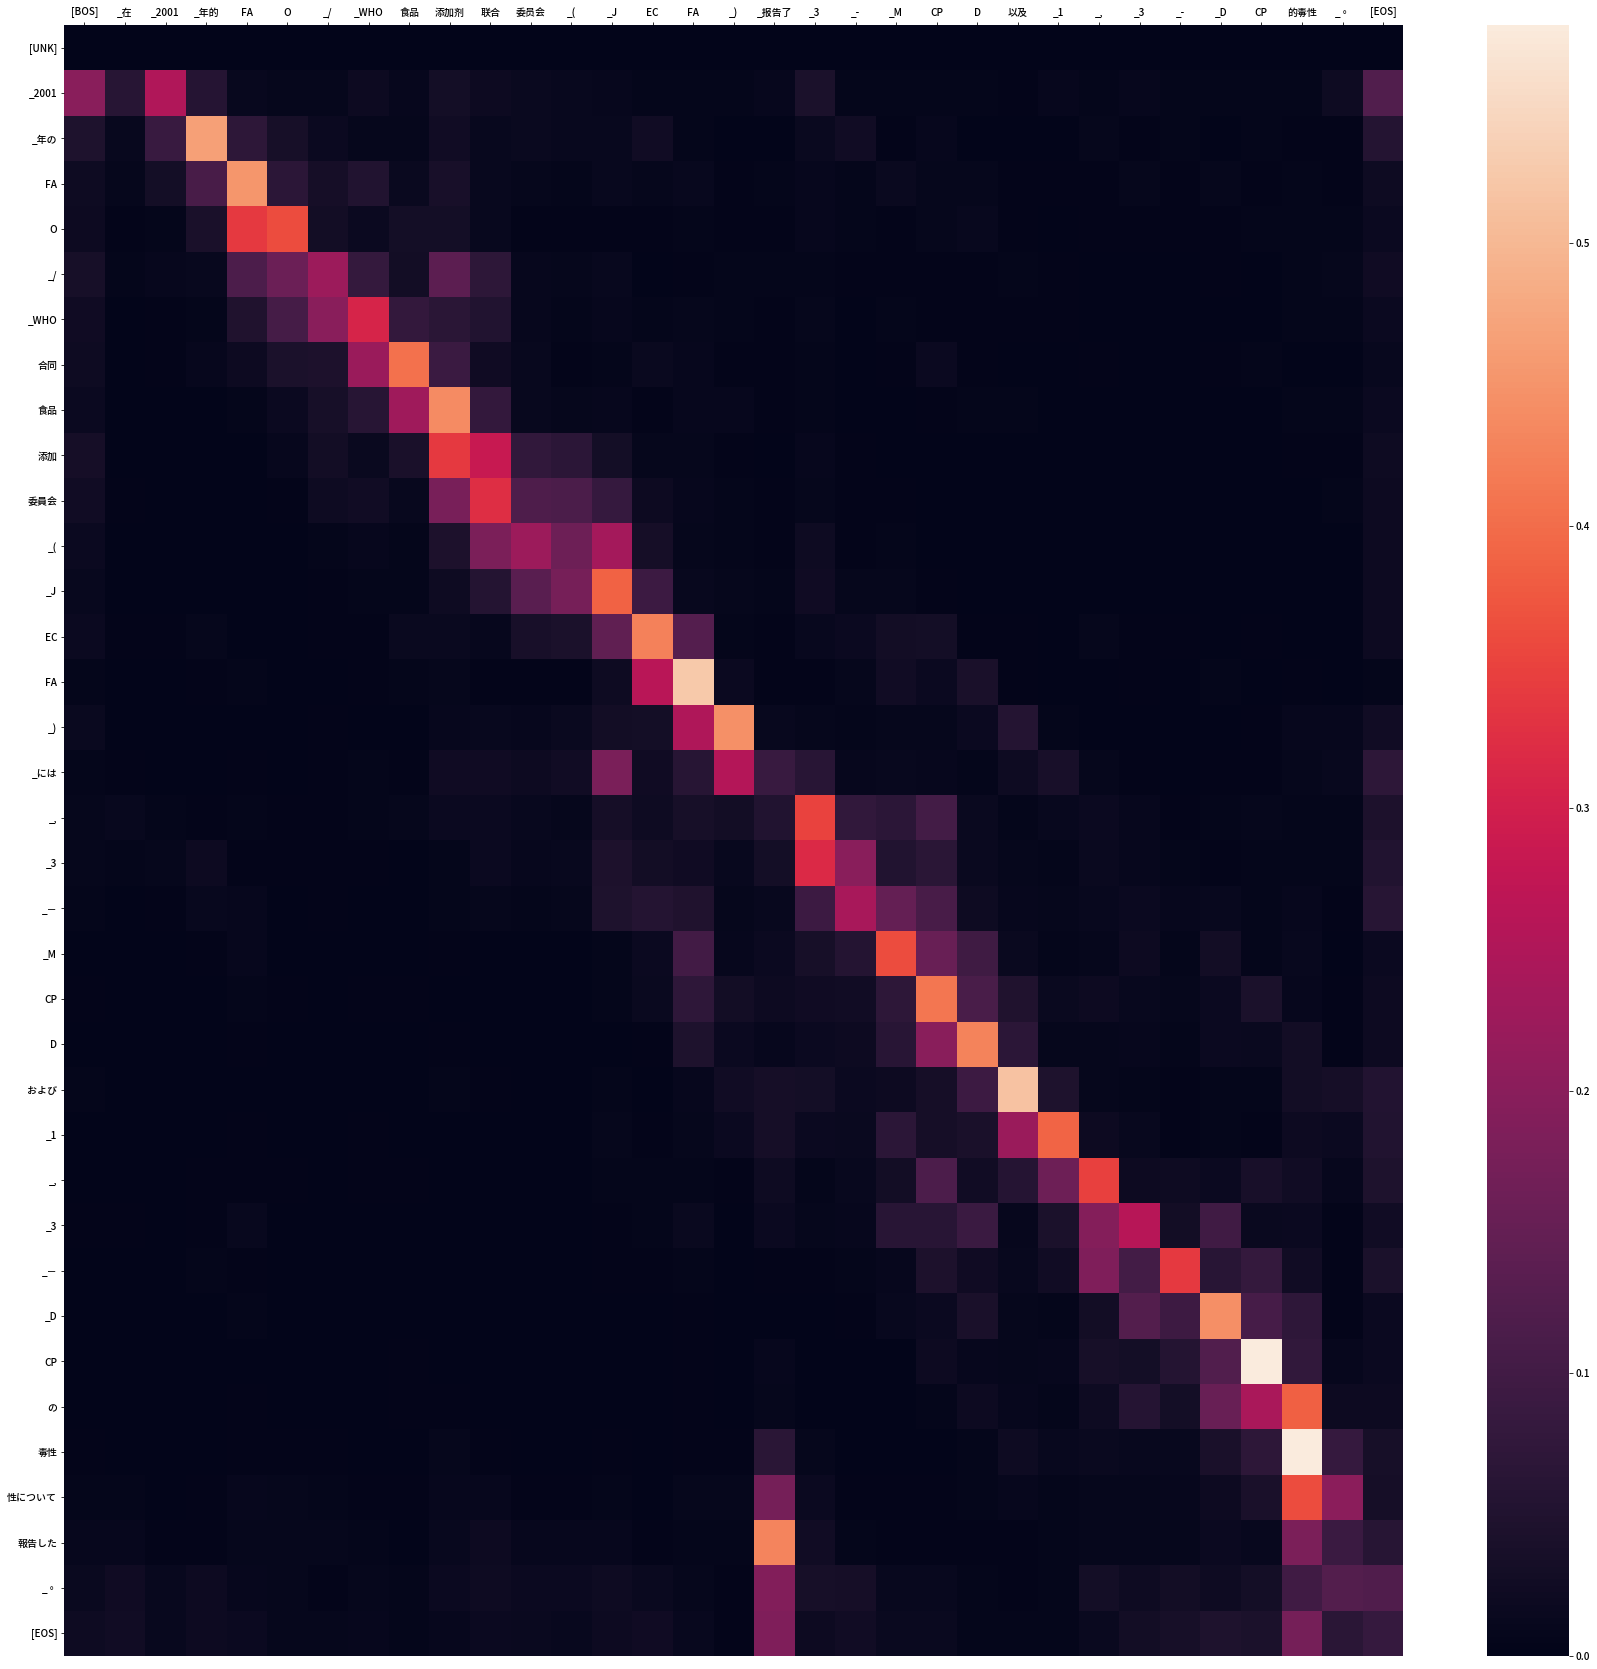

In [27]:
i=13
case_study(model.test_outputs[i][0],
           model.test_outputs[i][2],
           model.test_outputs[i][3],
           model.test_outputs[i][1].cpu().numpy())